# Tutorial 10: Adversarial attacks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)  
**Pre-trained models and dataset:**
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial10)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1k01P6w31VOW9TT0gTEP9kog315qyiXCd?usp=sharing)  
**Recordings:**
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/uidLtkhZFwY)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/Dmbz0ffc6Wg)
[![YouTube - Part 3](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%203&color=red)](https://youtu.be/0dt2Su-SRpI)    
**Author:** Phillip Lippe

In this tutorial, we will discuss adversarial attacks on deep image classification models. As we have seen in many of the previous tutorials so far, Deep Neural Networks are a very powerful tool to recognize patterns in data, and, for example, perform image classification on a human-level. However, we have not tested yet how robust these models actually are. Can we "trick" the model and find failure modes? Can we design images that the networks naturally classify incorrectly? Due to the high classification accuracy on unseen test data, we would expect that this can be difficult. However, in 2014, a research group at Google and NYU showed that deep CNNs can be easily fooled, just by adding some salient but carefully constructed noise to the images. For instance, take a look at the example below (figure credit - [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf)):

<center width="100%" style="padding: 20px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/adversarial_example.svg?raw=1" width="550px"></center>

The image on the left is the original image from ImageNet, and a deep CNN classifies the image correctly as "panda" with a class likelihood of 57%. Nevertheless, if we add a little noise to every pixel of the image, the prediction of the model changes completely. Instead of a panda, our CNN tells us that the image contains a "gibbon" with the confidence of over 99%. For a human, however, these two images look exactly alike, and you cannot distinguish which one has noise added and which doesn't. While this first seems like a fun game to fool trained networks, it can have a serious impact on the usage of neural networks. More and more deep learning models are used in applications, such as for example autonomous driving. Imagine that someone who gains access to the camera input of the car, could make pedestrians "disappear" for the image understanding network by simply adding some noise to the input as shown below (the figure is taken from [J.H. Metzen et al.](https://openaccess.thecvf.com/content_ICCV_2017/papers/Metzen_Universal_Adversarial_Perturbations_ICCV_2017_paper.pdf)). The first row shows the original image with the semantic segmentation output on the right (pedestrians red), while the second row shows the image with small noise and the corresponding segmentation prediction. The pedestrian becomes invisible for the network, and the car would think the road is clear ahead.

<center width="100%" style="padding: 20px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/adversarial_attacks_cityscapes_3.png?raw=1" width="600px"></center>

Some attack types don't even require to add noise, but minor changes on a stop sign can be already sufficient for the network to recognize it as a "50km/h" speed sign ([paper](https://arxiv.org/pdf/1707.08945.pdf), [paper](https://arxiv.org/pdf/1802.06430.pdf)). The consequences of such attacks can be devastating. Hence, every deep learning engineer who designs models for an application should be aware of the possibility of adversarial attacks.

To understand what makes CNNs vulnerable to such attacks, we will implement our own adversarial attack strategies in this notebook, and try to fool a deep neural network. Let's begin with importing our standard libraries:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the index of your GPU


In [2]:
import torch
# Print information about available GPU devices
print("Number of available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 2060


In [3]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("No GPU found. Using CPU.")

GPU is available!


In [4]:
print(torch.version.cuda)

12.1


In [5]:
import torch

print("PyTorch CUDA version:", torch.version.cuda)

PyTorch CUDA version: 12.1


In [6]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
#DATASET_PATH = "../data"
DATASET_PATH = "E:/data"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18420\97243397.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Using device cuda:0


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

## Deep CNNs on ImageNet

For our experiments in this notebook, we will use common CNN architectures trained on the ImageNet dataset. Such models are luckily provided by PyTorch's torchvision package, and hence we just need to load the model of our preference. For the results on the website and default on Google Colab, we use a ResNet34. Feel free to experiment with other architectures as well, the code is mainly independent of the specific architecture we choose.

In [7]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.alexnet(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset (note that this dataset is shared under the same [license](http://image-net.org/download-faq) as the original ImageNet dataset). Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [8]:
import os
import json
import numpy as np
import zipfile
from torchvision import transforms, datasets
from torch.utils import data

# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Path to the zip file
zip_file_path = "E:/data/TinyImageNet.zip"

# Directory where you want to extract the contents of the zip file
extracted_folder_path = "E:/data/TinyImageNet"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Update the path to the extracted folder
imagenet_path = os.path.join(extracted_folder_path, "TinyImageNet")

# Load dataset and create data loader
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     "Please make sure to have extracted the contents of the zip file."

dataset = datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)


Before we start with our attacks, we should verify the performance of our model. As ImageNet has 1000 classes, simply looking at the accuracy is not sufficient to tell the performance of a model. Imagine a model that always predicts the true label as the second-highest class in its softmax output. Although we would say it recognizes the object in the image, it achieves an accuracy of 0. In ImageNet with 1000 classes, there is not always one clear label we can assign an image to. This is why for image classifications over so many classes, a common alternative metric is "Top-5 accuracy", which tells us how many times the true label has been within the 5 most-likely predictions of the model. As models usually perform quite well on those, we report the error (1 - accuracy) instead of the accuracy:

In [9]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [10]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 28.12%
Top-5 error: 9.76%


The ResNet34 achives a decent error rate of 4.3% for the top-5 predictions. Next, we can look at some predictions of the model to get more familiar with the dataset. The function below plots an image along with a bar diagram of its predictions. We also prepare it to show adversarial examples for later applications.

In [13]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    print(topk_vals)
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Let's visualize a few images below:

[0.90601754 0.0450336  0.02367295 0.0131992  0.00650727]


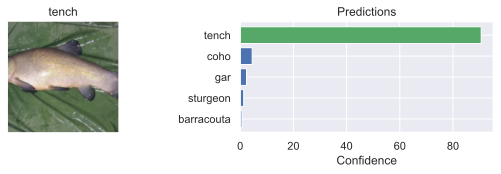

[9.9954307e-01 2.0868293e-04 5.1384486e-05 5.0393843e-05 2.2859189e-05]


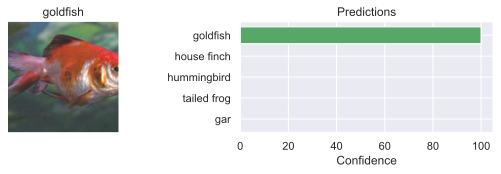

[9.9324667e-01 4.2319959e-03 5.4721895e-04 3.1365492e-04 3.0081393e-04]


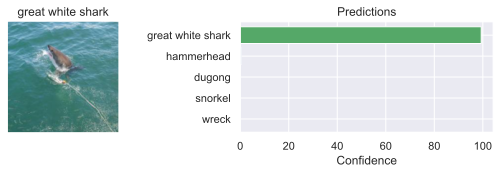

[0.85900444 0.07356699 0.00928358 0.00860349 0.00787817]


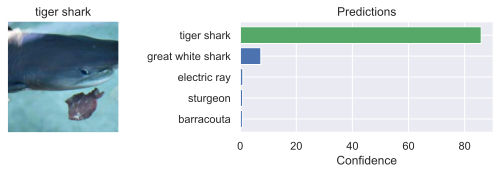

In [14]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in [0,6,13,18]:      #(1,32,8) (3,6,13,18)
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

The bar plot on the right shows the top-5 predictions of the model with their class probabilities. We denote the class probabilities with "confidence" as it somewhat resembles how confident the network is that the image is of one specific class. Some of the images have a highly peaked probability distribution, and we would expect the model to be rather robust against noise for those. However, we will see below that this is not always the case. Note that all of the images are of fish because the data loader doesn't shuffle the dataset. Otherwise, we would get different images every time we run the notebook, which would make it hard to discuss the results on the static version.

## White-box adversarial attacks

There have been proposed many possible adversarial attack strategies, which all share the same goal: alternate the data/image input only a little bit to have a great impact on the model's prediction. Specifically, if we look at the ImageNet predictions above, how can we have to change the image of the goldfish so that the model does not recognize the goldfish anymore? At the same time, the label of the image should not change, in the sense that a human would still clearly classify it as a goldfish. This is the same objective that the generator network has in the Generative Adversarial Network framework: try to fool another network (discriminator) by changing its input.

Adversarial attacks are usually grouped into "white-box" and "black-box" attacks. White-box attacks assume that we have access to the model parameter and can, for example, calculate the gradients with respect to the input (similar as in GANs). Black-box attacks on the other hand have the harder task of not having any knowledge about the network, and can only obtain predictions for an image, but no gradients or the like. In this notebook, we will focus on white-box attacks as they are usually easier to implement and follow the intuition of Generative Adversarial Networks (GAN) as studied in lecture 10.

### Fast Gradient Sign Method (FGSM)

One of the first attack strategies proposed is Fast Gradient Sign Method (FGSM), developed by [Ian Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) in 2014. Given an image, we create an adversarial example by the following expression:

$$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta,x,y))$$

The term $J(\theta,x,y)$ represents the loss of the network for classifying input image $x$ as label $y$; $\epsilon$ is the intensity of the noise, and $\tilde{x}$ the final adversarial example. The equation resembles SGD and is actually nothing else than that. We change the input image $x$ in the direction of *maximizing* the loss $J(\theta,x,y)$. This is exactly the other way round as during training, where we try to minimize the loss. The sign function and $\epsilon$ can be seen as gradient clipping and learning rate specifically. We only allow our attack to change each pixel value by $\epsilon$. You can also see that the attack can be performed very fast, as it only requires a single forward and backward pass. Let's implement it below:

In [15]:
def carlini_wagner_attack(model, imgs, labels, epsilon=0.01, confidence=0, max_iterations=100, learning_rate=0.01):
    # Clone input images and require gradients
    adv_imgs = imgs.clone().requires_grad_()

    for iteration in range(max_iterations):
        # Forward pass to get model predictions
        preds = model(adv_imgs.to(device))
        preds = F.log_softmax(preds, dim=-1)

        # Calculate the targeted loss
        target_one_hot = F.one_hot(labels.to(device), num_classes=preds.shape[-1]).float()
        attack_loss = (1 - confidence) * F.nll_loss(preds, labels.to(device)) + confidence * torch.sum((adv_imgs - imgs) ** 2)

        # Backward pass to compute gradients
        model.zero_grad()
        attack_loss.backward()

        # Update image to adversarial example using gradient descent
        adv_imgs.data += learning_rate * adv_imgs.grad.sign()
        adv_imgs.data = torch.clamp(adv_imgs.data, imgs.data - epsilon, imgs.data + epsilon)
        adv_imgs.grad.zero_()

    return adv_imgs.detach()

The default value of $\epsilon=0.02$ corresponds to changing a pixel value by about 1 in the range of 0 to 255, e.g. changing 127 to 128. This difference is marginal and can often not be recognized by humans. Let's try it below on our example images:

[0.41440424 0.2885568  0.26388812 0.01460797 0.00835748]


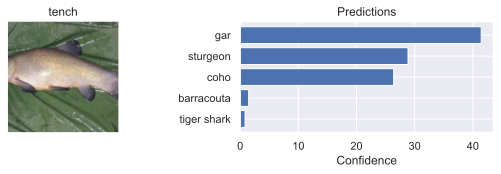

[0.4003055  0.25171342 0.21575102 0.04296935 0.0108467 ]


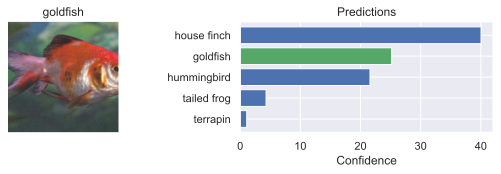

[0.79664665 0.1488801  0.01406495 0.01153904 0.00565211]


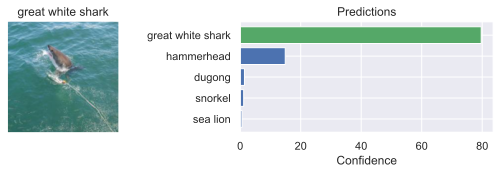

[0.4187674  0.06959537 0.04226901 0.04194307 0.03789992]


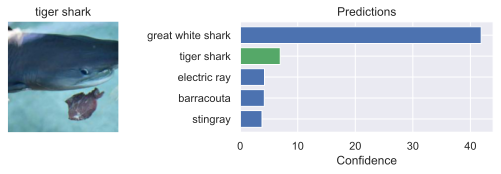

In [16]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.01, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.49186507 0.34268424 0.15053518 0.00490871 0.0034191 ]


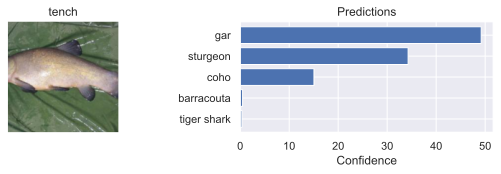

[0.41275468 0.35689786 0.0414208  0.03406227 0.01601758]


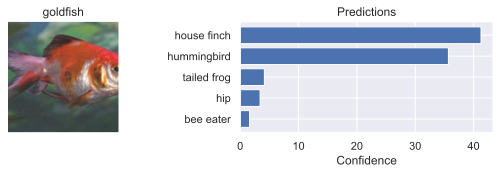

[0.43305162 0.37323833 0.05089631 0.04839144 0.0174721 ]


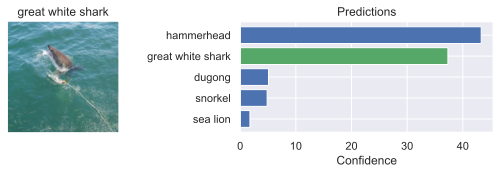

[0.2925704  0.06089529 0.05836867 0.03608627 0.02995492]


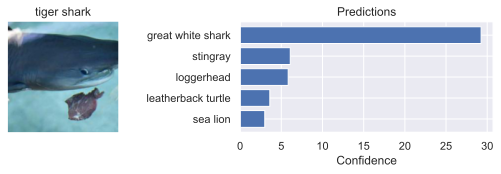

In [17]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.02, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.48692247 0.36592138 0.13069333 0.0048694  0.00261952]


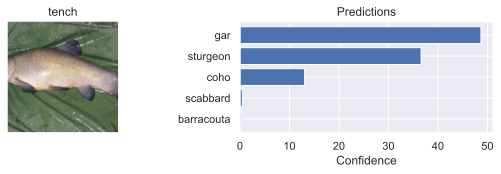

[0.38996348 0.24268843 0.05666491 0.04188745 0.03400535]


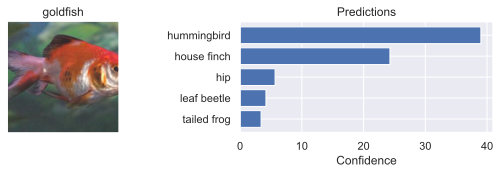

[0.53769857 0.17001767 0.07284597 0.06427892 0.0212851 ]


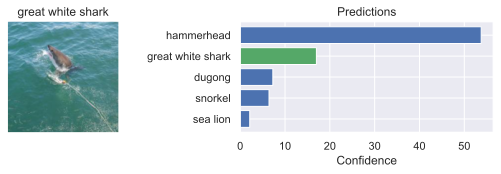

[0.17659795 0.10435051 0.07762603 0.05337497 0.0523655 ]


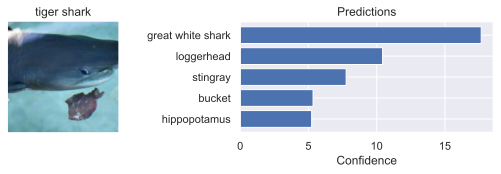

In [18]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.03, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.4710938  0.37983125 0.12536143 0.00876002 0.00506954]


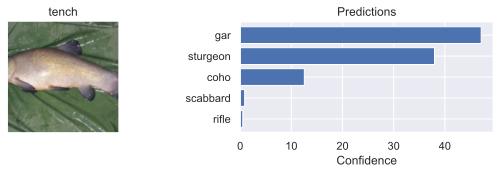

[0.32060862 0.13171586 0.12242987 0.04905859 0.0359672 ]


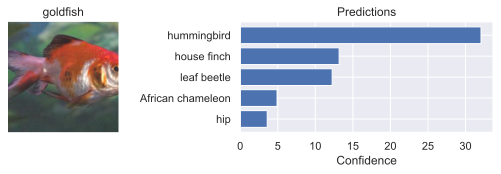

[0.53903115 0.09813585 0.08504345 0.06680779 0.02008644]


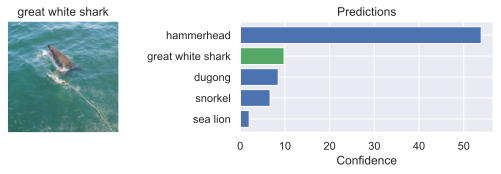

[0.14696835 0.11125135 0.11067493 0.08588438 0.0578138 ]


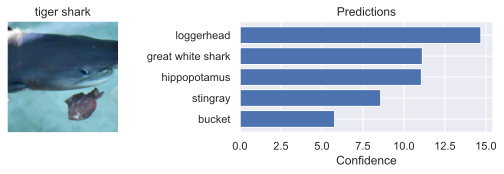

In [19]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.04, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.5186043  0.33924636 0.10845228 0.01384144 0.0084767 ]


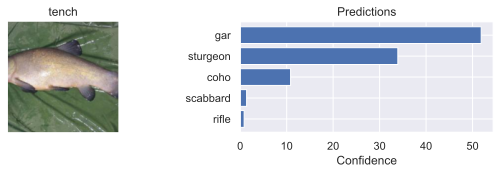

[0.23210713 0.18984835 0.07933575 0.07652278 0.05134215]


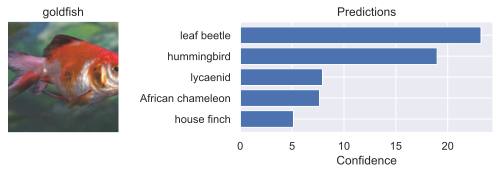

[0.48901144 0.09196142 0.07327492 0.06369247 0.02220616]


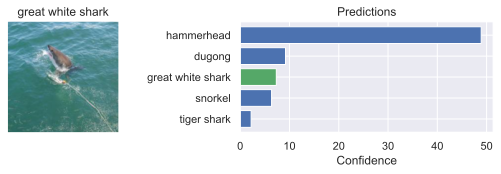

[0.20823205 0.16230063 0.07684341 0.06447462 0.05187477]


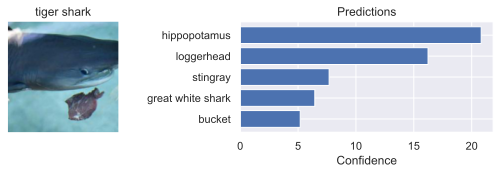

In [20]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.05, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.55271447 0.3076428  0.09682874 0.01918803 0.01049287]


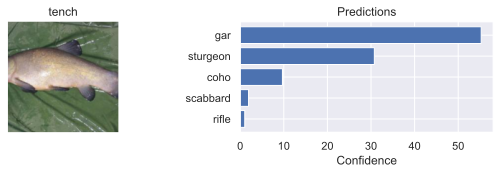

[0.31099376 0.11863659 0.08738792 0.07182702 0.05747662]


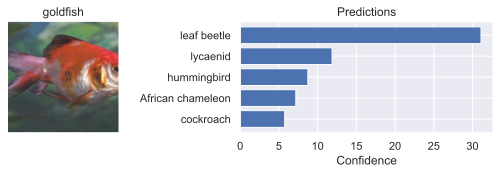

[0.4279101  0.10011622 0.05628869 0.05062265 0.02727601]


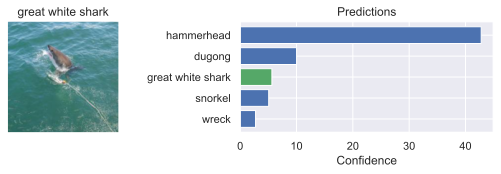

[0.3201823  0.15386471 0.05193088 0.04828717 0.04260978]


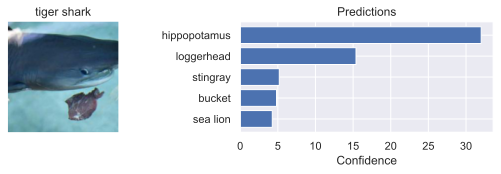

In [21]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.06, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.58498216 0.26728368 0.08815105 0.02943859 0.01333134]


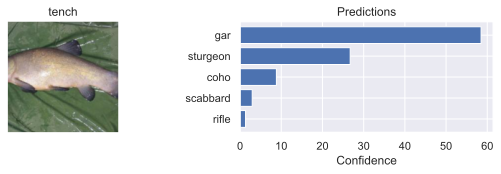

[0.33170193 0.14039506 0.0655253  0.06420414 0.0469082 ]


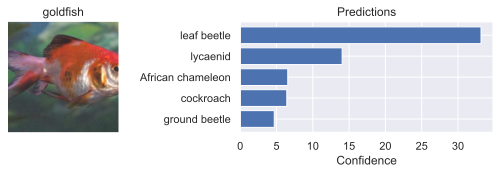

[0.3599224  0.11190463 0.04228288 0.0340603  0.03401029]


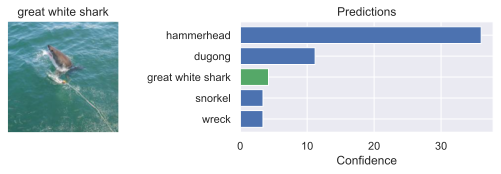

[0.38205126 0.13492015 0.04132444 0.0388841  0.03708195]


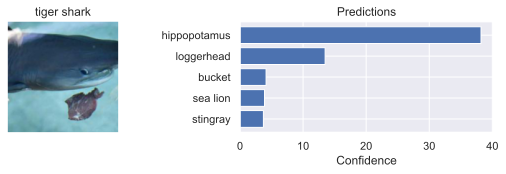

In [22]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.07, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.57538736 0.25240442 0.07972126 0.04701998 0.01879696]


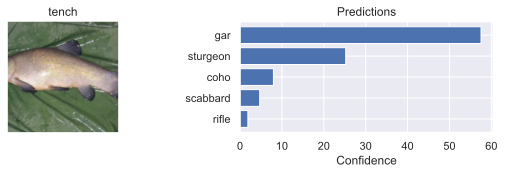

[0.32710087 0.14757165 0.07378861 0.06063623 0.05006319]


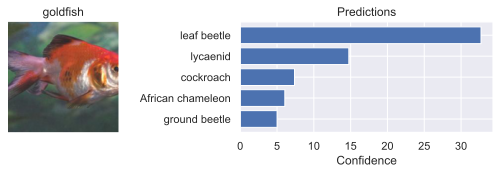

[0.27137518 0.11875941 0.03688512 0.03670064 0.02815314]


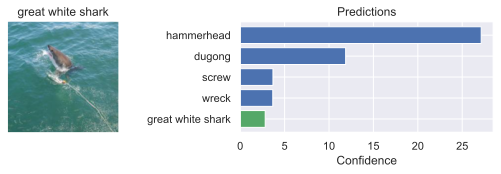

[0.39129344 0.117795   0.03841493 0.03554668 0.03266669]


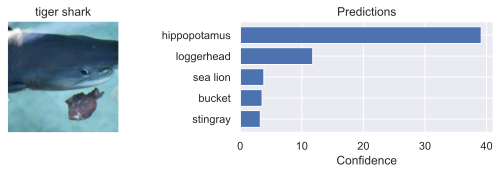

In [23]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.08, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.5117393  0.25206554 0.08015139 0.07859183 0.02831522]


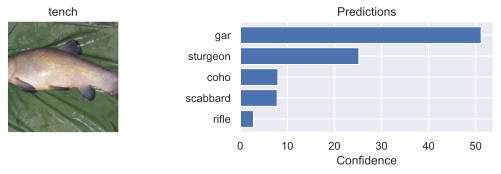

[0.29878873 0.15128134 0.08460756 0.05737219 0.04445704]


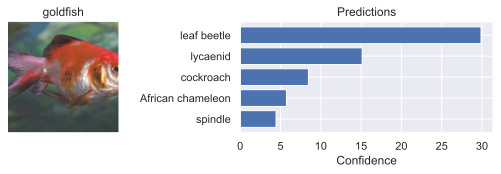

[0.18593615 0.11057666 0.06994704 0.06339415 0.03348428]


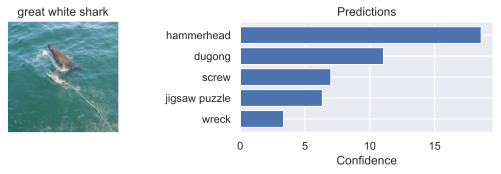

[0.3451611  0.11070491 0.03590027 0.03440526 0.02953123]


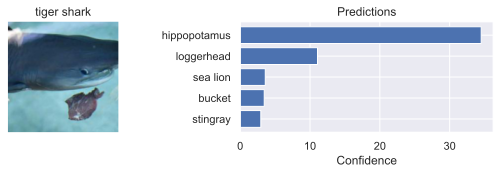

In [24]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.09, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

[0.43016922 0.24133806 0.11971245 0.0798051  0.03708901]


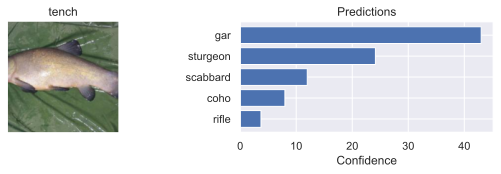

[0.2382536  0.15626767 0.08094151 0.05695441 0.05151736]


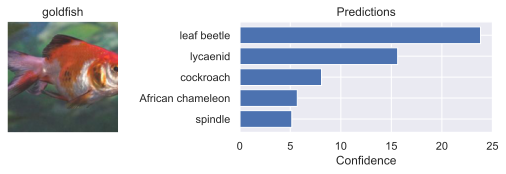

[0.12998123 0.12483929 0.10069793 0.09337067 0.03788332]


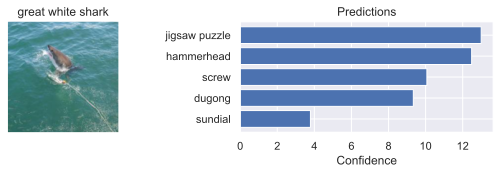

[0.30461037 0.10120679 0.03346587 0.03268136 0.0320453 ]


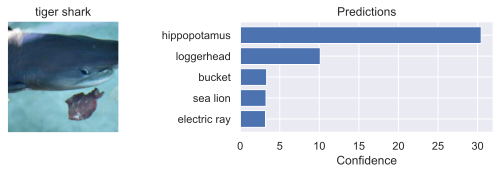

In [25]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.10, confidence=0.5)
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

# Visualize selected examples
for i in [0, 6, 13, 18]:
    show_prediction(exmp_batch[i], label_batch[i], adv_preds_carlini[i], adv_img=adv_imgs_carlini[i])

In [26]:
def carlini_wagner_attack(model, imgs, labels, epsilon=0.01, confidence=0.5, max_iterations=100, learning_rate=0.01):
    adv_imgs = imgs.clone().requires_grad_()

    for iteration in range(max_iterations):
        preds = model(adv_imgs.to(device))
        preds = F.log_softmax(preds, dim=-1)

        target_one_hot = F.one_hot(labels.to(device), num_classes=preds.shape[-1]).float()
        attack_loss = (1 - confidence) * F.nll_loss(preds, labels.to(device)) + confidence * torch.sum((adv_imgs - imgs) ** 2)

        model.zero_grad()
        attack_loss.backward()

        adv_imgs.data += learning_rate * torch.sign(adv_imgs.grad.data)
        adv_imgs.data = torch.clamp(adv_imgs.data, imgs.data - epsilon, imgs.data + epsilon)
        adv_imgs.grad.data.zero_()

    return adv_imgs.unsqueeze(0).detach()

In [27]:
# Example usage
adv_imgs_carlini = carlini_wagner_attack(pretrained_model, exmp_batch, label_batch, epsilon=0.01, confidence=0.5)
adv_imgs_carlini = adv_imgs_carlini.squeeze(0)  # Squeeze the batch dimension
with torch.no_grad():
    adv_preds_carlini = pretrained_model(adv_imgs_carlini.to(device))

In [28]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.01, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 78.72%
Top-5 error: 43.92%


In [34]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.02, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 92.00%
Top-5 error: 65.00%


In [35]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.03, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 96.38%
Top-5 error: 76.04%


In [36]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.04, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 97.98%
Top-5 error: 82.00%


In [37]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.05, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 98.78%
Top-5 error: 85.50%


In [38]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.06, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 99.00%
Top-5 error: 88.30%


In [39]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.07, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 99.26%
Top-5 error: 89.74%


In [40]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.08, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 99.30%
Top-5 error: 91.08%


In [41]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.09, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 99.30%
Top-5 error: 91.90%


In [42]:
_ = eval_model(data_loader, img_func=lambda x, y: carlini_wagner_attack(pretrained_model, x, y, epsilon=0.10, confidence=0.5)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 99.42%
Top-5 error: 92.78%


Despite the minor amount of noise, we are able to fool the network on all of our examples. None of the labels have made it into the top-5 for the four images, showing that we indeed fooled the model. We can also check the accuracy of the model on the adversarial images:

As expected, the model is fooled on almost every image at least for the top-1 error, and more than half don't have the true label in their top-5. This is a quite significant difference compared to the error rate of 4.3% on the clean images. However, note that the predictions remain semantically similar. For instance, in the images we visualized above, the tench is still recognized as another fish, as well as the great white shark being a dugong. FGSM could be adapted to increase the probability of a specific class instead of minimizing the probability of a label, but for those, there are usually better attacks such as the adversarial patch.

Although none of the images have anything to do with an American school bus, the high confidence of often 100% shows how powerful such attacks can be. With a few lines of code and access to the model, we were able to generate patches that we add to any image to make the model predict any class we want.

## Protecting against adversarial attacks

There are many more attack strategies than just FGSM and adversarial patches that we haven't discussed and implemented ourselves here. However, what about the other perspective? What can we do to *protect* a network against adversarial attacks? The sad truth to this is: not much.

White-box attacks require access to the model and its gradient calculation. The easiest way of preventing this is by ensuring safe, private storage of the model and its weights. However, some attacks, called black-box attacks, also work without access to the model's parameters, or white-box attacks can also generalize as we have seen above on our short test on transferability.

So, how could we eventually protect a model? An intuitive approach would to train/finetune a model on such adversarial images, leading to an adversarial training similar to a GAN. During training, we would pretend to be the attacker, and use for example FGSM as an augmentation strategy. However, this usually just ends up in an oscillation of the defending network between weak spots. Another common trick to increase robustness against adversarial attacks is defensive distillation ([Papernot et al.](https://arxiv.org/pdf/1511.04508.pdf)). Instead of training the model on the dataset labels, we train a secondary model on the softmax predictions of the first one. This way, the loss surface is "smoothed" in the directions an attacker might try to exploit, and it becomes more difficult for the attacker to find adversarial examples. Nevertheless, there hasn't been found the one, true strategy that works against all possible adversarial attacks.

Why are CNNs, or neural networks in general, so vulnerable to adversarial attacks? While there are many possible explanations, the most intuitive is that neural networks don't know what they don't know. Even a large dataset represents just a few sparse points in the extremely large space of possible images. A lot of the input space has not been seen by the network during training, and hence, we cannot guarantee that the prediction for those images is any useful. The network instead learns a very good classification on a smaller region, often referred to as manifold, while ignoring the points outside of it. NNs with uncertainty prediction could potentially help to discover what the network does not know.
Another possible explanation lies in the activation function. As we know, most CNNs use ReLU-based activation functions. While those have enabled great success in training deep neural networks due to their stable gradient for positive values, they also constitute a possible flaw. The output range of a ReLU neuron can be arbitrarily high. Thus, if we design a patch or the noise in the image to cause a very high value for a single neuron, it can overpower many other features in the network. Thus, although ReLU stabilizes training, it also offers a potential point of attack for adversaries.

## Conclusion

In this tutorial, we have looked at different forms of adversarial attacks. Deep CNNs can be fooled by only slight modifications to the input. Whether it is a carefully designed noise pattern, unnoticeable for a human, or a small patch, we are able to manipulate the networks' predictions significantly. The fact that even white-box attacks can be transferable across networks, and that there exist no suitable protections against all possible adversarial attacks, make this concept a massive problem for real-world applications. While adversarial attacks can also be used for improving/training a robust model or a GAN, it is not close to being solved yet. This is also because neural networks are currently complex, unknown non-linear functions in high-dimensional looking for correlations instead of causation. In the next years, we might hopefully see an improvement in the stability of such models by using causal approaches and/or introducing uncertainty.

## References

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub.

---